In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [60]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc, distinct 

In [5]:
# create engine to hawaii.sqlite 
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
# Displaying the first 5 rows in Measurements
for row in session.query(Measurement).limit(5).all():
    print(row.id, row.station)

1 USC00519397
2 USC00519397
3 USC00519397
4 USC00519397
5 USC00519397


In [13]:
# Displaying the first 5 rows in Station
for row in session.query(Station).limit(5).all():
    print(row.id, row.name)

1 WAIKIKI 717.2, HI US
2 KANEOHE 838.1, HI US
3 KUALOA RANCH HEADQUARTERS 886.9, HI US
4 PEARL CITY, HI US
5 UPPER WAHIAWA 874.3, HI US


# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
record = session.query(Measurement).order_by(desc(Measurement.date)).limit(1).one()

most_recent_date = dt.datetime.strptime(record.date, '%Y-%m-%d')
print('most recent date in the dataset:', most_recent_date)

most recent date in the dataset: 2017-08-23 00:00:00


date one year from the last date in dataset: 2016-08-23 00:00:00
(365, 4)


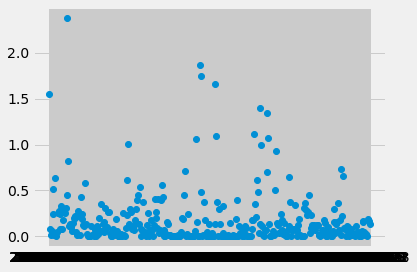

In [81]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_previous = most_recent_date - dt.timedelta(days=365)
print('date one year from the last date in dataset:', year_previous)


# Perform a query to retrieve the data and precipitation scores
records = session.query(
    Measurement.date,
    func.min(Measurement.prcp),
    func.max(Measurement.prcp),
    func.avg(Measurement.prcp),
).filter(
    Measurement.date > year_previous
).group_by(
    Measurement.date
).all()

df_data = []
for row in records:
    df_data.append({
        'date': row[0],
        'prcp_min': row[1],
        'prcp_max': row[2],
        'prcp_avg': row[3],
    })

# Save the query results as a Pandas DataFrame and set the index to the date column
df_data = pd.DataFrame(df_data)
df_data.index = list(df_data.date)
print(df_data.shape)


# Sort the dataframe by date
df_data.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot_date(df_data.date, df_data.prcp_avg)
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data


# Exploratory Station Analysis

In [66]:
# Design a query to calculate the total number stations in the dataset
(count,) = session.query(
    func.count(distinct(Station.id)),
).one()

print('total number stations in the dataset', count)

total number stations in the dataset 9


In [70]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
records = session.query(
    Station,
    func.count(Measurement.id)
).join(
    Measurement,
    Measurement.station == Station.station
).group_by(
    Measurement.station
).order_by(
    desc(func.count(Measurement.id))
).all()

active_stations = []
for row in records:
    station = {
        "id": row.station.id,
        "station": row.station.station,
        "name": row.station.name,
        "latitude": row.station.latitude,
        "longitude": row.station.longitude,
        "elevation": row.station.elevation,
        "meassurement_count": row[1],
    }
    active_stations.append(station)

df_active = pd.DataFrame(active_stations)
df_active

,id,station,name,latitude,longitude,elevation,meassurement_count
0,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2772
1,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2724
2,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2709
3,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2669
4,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2612
5,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2202
6,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,1979
7,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,1372
8,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,511


In [80]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = df_active.loc[0]['station']

records = session.query(
    Station,
    Measurement,
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs),
).join(
    Measurement,
    Measurement.station == Station.station
).group_by(
    Measurement.station
).filter(
    Station.station == most_active_station
).all()

most_active_meassurements = []
for row in records:
    station = {
        "id": row.station.id,
        "station": row.station.station,
        "name": row.station.name,
        "latitude": row.station.latitude,
        "longitude": row.station.longitude,
        "elevation": row.station.elevation,
        "min": row[2],
        "max": row[3],
        "avg": row[4],
    }
    most_active_meassurements.append(station)

df_most_active_meassurements = pd.DataFrame(most_active_meassurements)

df_most_active_meassurements.T

,0
id,7
station,USC00519281
name,"WAIHEE 837.5, HI US"
latitude,21.45167
longitude,-157.84889
elevation,32.9
min,54.0
max,85.0
avg,71.663781


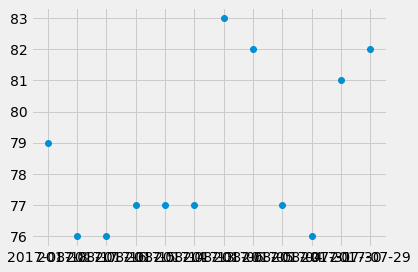

In [84]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

records = session.query(
    Measurement,
).filter(
    Measurement.station == most_active_station
).order_by(
    desc(Measurement.date)
).limit(12).all()

df_data = []
for row in records:
    df_data.append({
        'date': row.date,
        'temp': row.tobs,
    })

# Save the query results as a Pandas DataFrame and set the index to the date column
df_data = pd.DataFrame(df_data)
df_data.index = list(df_data.date)

# Sort the dataframe by date
df_data.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot_date(df_data.date, df_data.temp)
plt.tight_layout()
plt.show()

# Close session

In [20]:
# Close Session
session.close()